- **Author**: Jaehyuk Heo
- **RetinaNet paper**: [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
- **keras examples**: https://keras.io/examples/vision/retinanet/
- **pytorch source code**: https://github.com/yhenon/pytorch-retinanet

**TIL**

- Architectures
    - Feature Pyramid Network (FPN)
    - RetinaNet
- Focal Loss
- Metrics
    - Intersection over Union (IoU)
    - mean Average Precision (mAP)
- Decoder
    - Anchor Box
    - Non-Maximum Suppression (NMS)


# Architectures

## FPN

<p align='center'>
    <img width='700' src="https://user-images.githubusercontent.com/37654013/157783790-0b619fc0-9ba5-4450-9064-a1a79a19ce7d.png">
</p>


## RetinaNet

<p align='center'>
    <img width='700' src="https://user-images.githubusercontent.com/37654013/157783956-912e3670-14cf-40c7-94e5-a0ce58ae93f9.png">
</p>

# Focal Loss

<p align='center'>
    <img width='500' src="https://user-images.githubusercontent.com/37654013/157784042-b5b603a7-2199-49ec-8135-5556415dd554.png">
</p>

# Metrics

## Intersection over Union (IoU)

<p align='center'>
    <img width='500' src='https://user-images.githubusercontent.com/37654013/158098507-2bb3e9b7-b885-4eba-82b7-a853ef4e831e.png'>
</p>


## mean Average Precision (mAP)

- Precision-Recall Curve의 면적을 class 별로 계산한 후 평균 낸 값
- $mAP_{50}$ 과 같이 아래 숫자가 붙는 경우는 IoU > 0.5에 해당하는 bounding box를 기준으로 한 것
- MS COCO의 경우 아래와 같이 표시함
    > $mAP_{COCO} = \frac{mAP_{0.50} + mAP_{0.55} + \cdot + mAP_{0.95}}{10}$

<p align='center'>
    <img width='700' src='https://user-images.githubusercontent.com/37654013/158099195-3f839129-2c39-4f3c-b3d0-448cd80f42d7.png'>
</p>

# Decoder

## Anchor Box

<p align='center'>
    <img width='500' src='https://user-images.githubusercontent.com/37654013/158007815-2c26487a-611a-4faa-be97-9822218a84d0.png'>
</p>

<p align='center'>
    <img width='500' src='https://user-images.githubusercontent.com/37654013/158007822-5b17a94d-ce87-47c6-8d58-0d0ecaf529a9.png'>
</p>

## Non-Maximum Suppression (NMS)


<p align='center'>
    <img width='500' src='https://user-images.githubusercontent.com/37654013/158092974-8b623ee7-c80c-47ec-8197-e020194eb053.png'>
</p>

Arguments
- Predicted Bounding Boxes ($B$)
- IoU threshold ($I$)
- Confidence threshold ($C$)

Return
- Final Bounding Boxes ($B_f$)


Algorithms  
*아래 과정을 class 마다 수행*
1. Target class 에 해당하는 $B_c$ 중에 가장 $C$가 높은 $B_i$를 $B_f$에 추가
2. $B_f$와 $B$ 안에 있는 $B_i$들과 비교하여 IoU가 $I$ 이상인 $B_i$를 제거
3. 위 과정을 $B$ 안에 아무것도 없을때까지 반복 수행

Code
- torchvision.ops에서 nms 사용
- https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html#torchvision.ops.nms

---
Source example: https://deep-learning-study.tistory.com/403

```python
import torch

from IoU import intersection_over_union

def nms(bboxes, iou_threshold, threshold, box_format='corners'):

    # bboxes가 list인지 확인합니다.
    assert type(bboxes) == list

    # box 점수가 threshold보다 높은 것을 선별합니다.
    # box shape는 [class, score, x1, y1, x2, y2] 입니다.
    bboxes = [box for box in bboxes if box[1] > threshold]
    # 점수 오름차순으로 정렬합니다.
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nmn = []

    # bboxes가 모두 제거될때 까지 반복합니다.
    while bboxes:
        # 0번째 index가 가장 높은 점수를 갖고있는 box입니다. 이것을 선택하고 bboxes에서 제거합니다.
        chosen_box = bboxes.pop(0)

        # box가 선택된 box와의 iou가 임계치보다 낮거나
        # class가 다르다면 bboxes에 남기고, 그 이외는 다 없앱니다.
        bboxes = [box for box in bboxes if box[0] != chosen_box[0] \
               or intersection_over_union(torch.tensor(chosen_box[2:]),
                                          torch.tensor(box[2:]),
                                          box_format=box_format)
                    < iou_threshold]

        # 선택된 박스를 추가합니다.
        bboxes_after_nmn.append(chosen_box)

    return bboxes_after_nmn
```
---

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('./pytorch-retinanet/')

from retinanet.dataloader import CocoDataset, Resizer, Normalizer, Augmenter, UnNormalizer, AspectRatioBasedSampler, collater
from retinanet.losses import calc_iou
import retinanet.model as model
from retinanet.anchors import Anchors, generate_anchors

from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torchvision.transforms as transforms

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import torch.nn as nn

In [2]:
class Config:
    datadir = '/datasets/MSCOCO'
    traindir = 'train2017'
    valdir = 'val2017'
    
    batch_size = 4
    epochs = 1
    
args = Config()

# Load Data

- **data**: train2017, val2017
- **annotation**: instance_train2017.json, instance_val2017.json

In [3]:
trainset = CocoDataset(
    args.datadir, 
    set_name=args.traindir, 
    transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()])
)

validset = CocoDataset(
    args.datadir, 
    set_name=args.valdir, 
    transform=transforms.Compose([Normalizer(), Resizer()])
)

loading annotations into memory...
Done (t=12.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [4]:
print('validset.image_ids[0]: ',validset.image_ids[0])
image_info = validset.coco.loadImgs(validset.image_ids[0])[0]
image_info

validset.image_ids[0]:  397133


{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

## example

- bounding box label은 x1, y1, x2, y2으로 되어있음. (x1,y1): 좌하단 모서리, (x2, y2): 우상단 모서리

x, y, width, height: [217.62, 240.54, 38.99, 57.75]


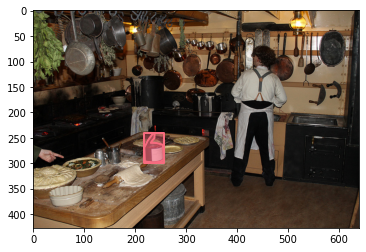

In [5]:
plt.imshow(validset.load_image(0))

# 0번째 image에 있는 objects ids
annot_ids = validset.coco.getAnnIds(imgIds=validset.image_ids[0], iscrowd=False)
annots = validset.coco.loadAnns(annot_ids)
validset.coco.showAnns(annots[:1], draw_bbox=True)

print(f"x, y, width, height: {annots[:1][0]['bbox']}")

## Make a dataloader

- collater
    - batch 내에서 image는 max width or max height 만큼 크기를 맞추어줌
    - annots bbox는 image 당 최대 annotation 개수를 기준으로 padding해서 맞춰줌
   
- sampler
    - 전체 image의 resolution ratio를 계산해서 오름차순으로 sampling

In [6]:
train_sampler = AspectRatioBasedSampler(trainset, batch_size=args.batch_size, drop_last=False)
trainloader = DataLoader(trainset, num_workers=3, collate_fn=collater, batch_sampler=train_sampler)

val_sampler = AspectRatioBasedSampler(validset, batch_size=args.batch_size, drop_last=False)
validloader = DataLoader(validset, num_workers=3, collate_fn=collater, batch_sampler=val_sampler)

## example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


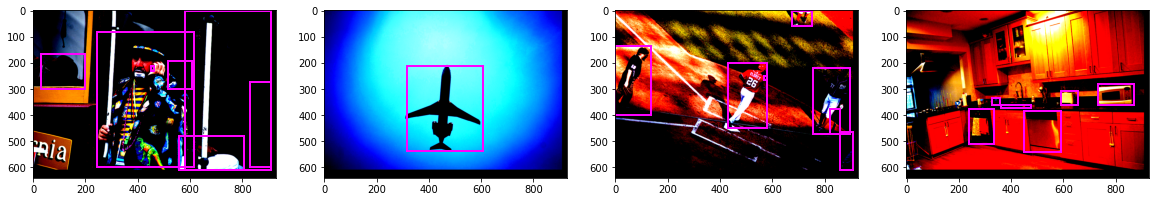

In [7]:
b = next(iter(validloader))

fig, ax = plt.subplots(1,args.batch_size, figsize=(20,5))

for i in range(args.batch_size):
    ax[i].imshow(b['img'][i].permute(1,2,0))

    for idx, box in enumerate(b['annot'][i]):
        x1, y1, x2, y2, _ = box
        w = x2 - x1
        h = y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=[1,0,1], linewidth=2
        )
        ax[i].add_patch(patch)

# Build a Model

In [11]:
retinanet = model.resnet18(num_classes=trainset.num_classes(), pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to ./resnet18-5c106cde.pth


# Training Process

- Image 별 최대 annotation 개수로 padding.
- Padding 된 부분은 -1로 채움

In [12]:
x = retinanet.conv1(b['img'])
x = retinanet.bn1(x)
x = retinanet.relu(x)
x = retinanet.maxpool(x)

x1 = retinanet.layer1(x)
x2 = retinanet.layer2(x1)
x3 = retinanet.layer3(x2)
x4 = retinanet.layer4(x3)

features = retinanet.fpn([x2, x3, x4])

regression = torch.cat([retinanet.regressionModel(feature) for feature in features], dim=1)

classification = torch.cat([retinanet.classificationModel(feature) for feature in features], dim=1)

In [13]:
for i in range(len(features)):
    print(features[i].shape)

torch.Size([4, 256, 80, 116])
torch.Size([4, 256, 40, 58])
torch.Size([4, 256, 20, 29])
torch.Size([4, 256, 10, 15])
torch.Size([4, 256, 5, 8])


In [14]:
regression.shape

torch.Size([4, 111330, 4])

In [15]:
classification.shape

torch.Size([4, 111330, 80])

## Anchors

In [19]:
anchors = Anchors()

In [20]:
anchors_b = anchors(b['img'])[0].cpu() # num_anchors x (x1, y1, x2, y2)
print(anchors_b.shape)

torch.Size([111330, 4])


In [21]:
generate_anchors().shape

(9, 4)

In [22]:
t = 1
for k in list(anchors.__dict__.keys())[-5:]:
    print(f'{k}: {anchors.__dict__[k]}')
    t *= len(anchors.__dict__[k])

pyramid_levels: [3, 4, 5, 6, 7]
strides: [8, 16, 32, 64, 128]
sizes: [32, 64, 128, 256, 512]
ratios: [0.5 1.  2. ]
scales: [1.         1.25992105 1.58740105]


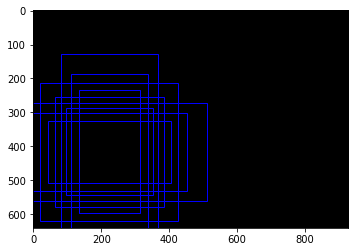

In [23]:
plt.imshow(np.zeros(b['img'][0].permute(1,2,0).size()))
ax = plt.gca()
for i, box in enumerate(anchors(b['img'])[0][-873:-864]):
    x1, y1, x2, y2 = box
    w = x2 - x1
    h = y2 - y1
    patch = plt.Rectangle(
        [x1, y1], w, h, fill=False, edgecolor=[0,0,1], linewidth=1
    )
    ax.add_patch(patch)
plt.show()

## Focal Loss

1. classification loss
2. regression loss

In [24]:
alpha = 0.25
gamma = 2.0

In [25]:
classification_i = classification[0, :, :]
regression_i = regression[0, :, :]

bbox_annotation = b['annot'][0, :, :]
bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1] # padding된 값 제외

print('classification_i.shape: ',classification_i.shape)
print('regression_i.shape: ',regression_i.shape)
print('bbox_annotation.shape: ',bbox_annotation.shape)

classification_i.shape:  torch.Size([111330, 80])
regression_i.shape:  torch.Size([111330, 4])
bbox_annotation.shape:  torch.Size([7, 5])


In [26]:
IoU_i = calc_iou(anchors_b, bbox_annotation[:, :4]) # bounding box 만 입력

In [27]:
IoU_i.shape # num_anchors x num_annotations

torch.Size([111330, 7])

In [28]:
# 각 anchor별로 가장 큰 IoU를 갖는 annotation을 indexing

IoU_max, IoU_argmax = torch.max(IoU_i, dim=1)
print('IoU_max: ',IoU_max.shape)
print('IoU_argmax: ',IoU_argmax.shape)
print()

# annotation 별 Anchor 수 : 여기서 각각의 anchor는 해당 anchor에 대해 가장 비슷한 annotation을 말함
print('IoU_argmax unique: ',np.unique(IoU_argmax, return_counts=True))

IoU_max:  torch.Size([111330])
IoU_argmax:  torch.Size([111330])

IoU_argmax unique:  (array([0, 1, 2, 3, 4, 5, 6]), array([59010,   517,  8696,  7642,  3605,  7672, 24188]))


### classification loss

$$\text{Focal Loss} = -\sum_{t=1}^{N_c}y_{t}\alpha(1-p_{t})^{\gamma}\log{(p_{t})} + (1-y_{t})(1 - \alpha)p_{t}^{\gamma}\log{(1-p_{t})}$$

- -1은 ignore : 학습에서 제외
    - 0.4 <= IoU (anchor & annotation) < 0.5
- 0은 negative : background
    - IoU (anchor & annotation) < 0.4
- 1은 positive : 정답에 대한 예측값
    - 0.5 <= IoU (anchor & annotation)

In [29]:
targets = torch.ones(classification[0].shape) * -1
targets

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [30]:
# torch.lt(IoU_max, 0.4) -> IoU_max < 0.4

print('torch.lt(IoU_max, 0.4).sum(): ',torch.lt(IoU_max, 0.4).sum())
targets[torch.lt(IoU_max, 0.4), :] = 0

torch.lt(IoU_max, 0.4).sum():  tensor(110827)


In [31]:
np.unique(targets, return_counts=True)

(array([-1.,  0.], dtype=float32), array([  40240, 8866160]))

In [32]:
# torch.ge(IoU_max, 0.5) -> IoU_max >= 0.5

positive_indices = torch.ge(IoU_max, 0.5)
num_positive_anchors = positive_indices.sum()
print("num_positive_anchors: ",num_positive_anchors)

num_positive_anchors:  tensor(164)


In [33]:
assigned_annotations = bbox_annotation[IoU_argmax, :]

print('assigned_annotations.shape: ',assigned_annotations.shape)

assigned_annotations.shape:  torch.Size([111330, 5])


In [34]:
targets[positive_indices, :] = 0
targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

np.unique(targets, return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([  27120, 8879116,     164]))

In [35]:
# alpha와 focal weight 계산

alpha_factor = torch.ones(targets.shape) * alpha

alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification_i, classification_i)
focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

# focal loss 계산

bce = -(targets * torch.log(classification_i) + (1.0 - targets) * torch.log(1.0 - classification_i))
cls_loss = focal_weight * bce

In [36]:
# -1에 대해서는 0으로 loss 설정

cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape))

In [75]:
cls_loss.shape

torch.Size([111330, 80])

In [72]:
classification_loss = cls_loss.sum()/torch.clamp(num_positive_anchors.float(), min=1.0)

In [74]:
classification_loss

tensor(1.1692, grad_fn=<DivBackward0>)

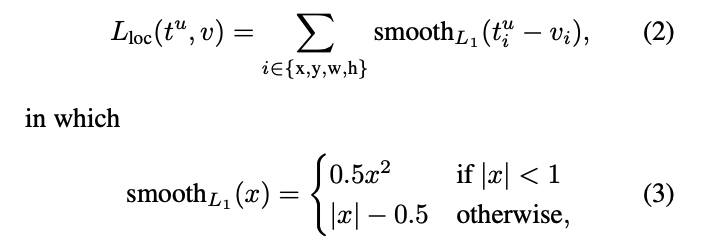

### regression loss

**R-CNN**
- paper : [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/pdf/1311.2524.pdf)

bounding box에 대한 regression은 아래와 같이 $P_{x}, P_{y}, P_{w}, P_{h}$가 ground truth로 transform하도록 $d(P)$를 학습함.  
여기서 $P_{x}$와 $P_{y}$는 좌표기 떄문에 이동만 시켜주면 되지만 $P_{w}$와 $P_{h}$는 이미지 크기에 비례해야 하기 때문에 scaling이 필요함.

$$\hat{G}_{x} = P_{w}d_{x}(P) + P_{x}$$
$$\hat{G}_{y} = P_{h}d_{y}(P) + P_{y}$$
$$\hat{G}_{w} = P_{w}\exp{(d_{w}(P))}$$
$$\hat{G}_{h} = P_{h}\exp{(d_{h}(P))}$$

이를 아래와 같이 $d(P)$에 대한 부분을 $t$로 치환해서 나타냄

$$t_{x} = (G_{x} - P_{x}) / P_{w}$$
$$t_{y} = (G_{y} - P_{y}) / P_{y}$$
$$t_{w} = \log{(G_{w}/P_{w})}$$
$$t_{h} = \log{(G_{h}/P_{h})}$$



**Faster R-CNN**
- paper: [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/pdf/1506.01497.pdf)

RetinaNet에서는 Anchor를 활용하여 학습하기 때문에 Faster R-CNN의 regression loss를 따름.  
각 anchor와 ground truth를 비교하여 anchor를 ground truth에 맞춰주는 transform $t$를 학습함. 즉, regression output은 $t_{x}, t_{y}, t_{w}, t_{h}$ 를 말함.

$$t_{x} = (x-x_{a}) / w_{a},\\ t_{y} = (y-y_{a})/h_{a},\\ t_{w} = \log{(w/w_{a})},\\ t_{h} = \log{(h/h_{a})},$$


$$t_{x}^{*} = (x^{*} - x_{a}) / w_{a},\\ t_{y}^{*} = (y^{*} - y_{a})/h_{a},\\ t_{w}^{*} = \log{(w^{*}/w_{a})},\\ t_{h}^{*} = \log{(h^{*}/h_{a})}$$


**Smooth L1 Loss**

Fast R-CNN에서 사용한 smooth L1 loss를 사용함. Paper에서는 sigma가 언급되어 있지 않지만 offical code를 보면 첨부되어 있음. (default sigma = 3)

- paper: [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)

$$L_{loc}(t^{u}, v) = \sum_{i \in {x,y,w,h}} \text{smooth}_{L_{1}} (t_{i}^{u} - v_{i}),$$

$$
\text{smooth}_{L_{1}}(x) = \left\{
    \begin{array}\\
        0.5 \sigma^{2} x^2  & \mbox{if |x| < 1} \\
        |x|-0.5 / \sigma^{2} & \mbox{otherwise,}
    \end{array}
\right.
$$

In [38]:
# assigned_annotations
# -> anchor 별 annotation들 중에 가장 IoU가 큰 annotation, dim: num_anchors x [dx, dy, dw, dh, target class idx]

# anchor와 IoU가 0.5 이상인 annotation
assigned_annotations = assigned_annotations[positive_indices, :]

In [39]:
# x1, y1, x2, y2을 사용하여 width, height, x_center, y_center 로 변환

# anchor
anchor_widths  = anchors_b[:, 2] - anchors_b[:, 0]
anchor_heights = anchors_b[:, 3] - anchors_b[:, 1]
anchor_ctr_x   = anchors_b[:, 0] + 0.5 * anchor_widths
anchor_ctr_y   = anchors_b[:, 1] + 0.5 *anchor_heights

# annotation
gt_widths  = assigned_annotations[:, 2] - assigned_annotations[:, 0]
gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
gt_ctr_x   = assigned_annotations[:, 0] + 0.5 * gt_widths
gt_ctr_y   = assigned_annotations[:, 1] + 0.5 * gt_heights

In [40]:
# positive 만 계산
anchor_widths_pi = anchor_widths[positive_indices]
anchor_heights_pi = anchor_heights[positive_indices]
anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

In [41]:
# clip widths to 1
gt_widths  = torch.clamp(gt_widths, min=1)
gt_heights = torch.clamp(gt_heights, min=1)

In [58]:
targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
targets_dw = torch.log(gt_widths / anchor_widths_pi)
targets_dh = torch.log(gt_heights / anchor_heights_pi)

targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
targets = targets.t() # num_positivie_anchor x [dx, dy, dw, dh]

print("targets.shape: ",targets.shape)

targets.shape:  torch.Size([164, 4])


In [65]:
targets.shape

torch.Size([164, 4])

In [66]:
# box variance 
targets = targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]])

regression_diff = torch.abs(targets - regression_i[positive_indices, :])

In [69]:
# smooth L1 loss (sigma = 3)
regression_loss = torch.where(
    torch.le(regression_diff, 1.0 / 9.0),
    0.5 * 9.0 * torch.pow(regression_diff, 2),
    regression_diff - 0.5 / 9.0
)

In [70]:
regression_loss.shape

torch.Size([164, 4])

In [76]:
regression_loss.mean()

tensor(8.3053, grad_fn=<MeanBackward0>)